# TP5

Objetivo:

1. Implementar el detector de fondo naive usando la mediana como estimador. El algoritmo debe recibir el parámetro N (cantidad de frames utilizados para la estimación) y el intervalo de tiempo para recalcular el fondo.
2. Se deben generar las mascaras de foreground y aplicarlas a los frames para segmentar los objetos en movimiento.
3. Comparar con alguno de los métodos vistos en la practica basados en mezcla de gaussianas


## Naive Background Substraction

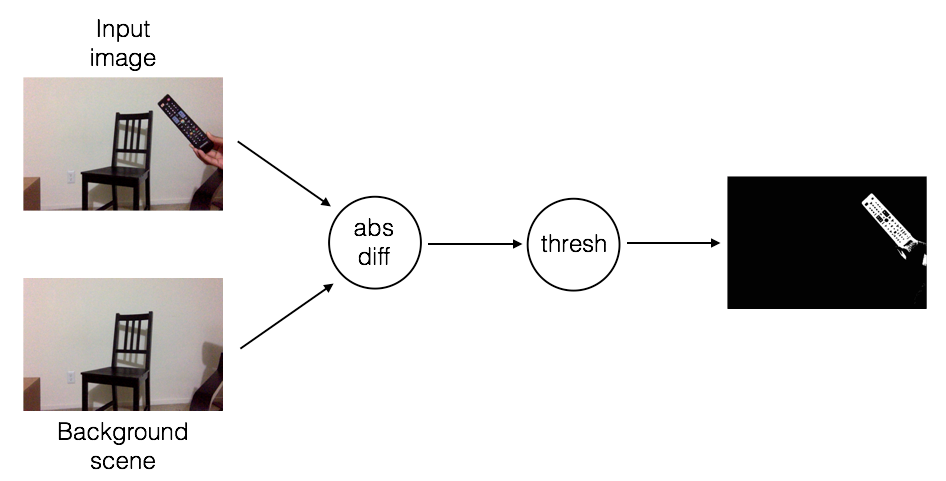

1. Se eligen N frames aleatorios y se calcula la mediana (background).
2. Se resta el frame actual con la mediana y se binariza para obtener la mascara del objeto (foreground)
3. Cada cierto intervalo se actualiza el modelo de background recalculando la mediana.

In [1]:
import cv2 as cv
import numpy as np
import time
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 16.0)

In [2]:
class NaiveBackgroundSubstraction:
    
    def __init__(self, n_frames, time_interval, filename, output_path=None):
        self.capture = cv.VideoCapture(filename)        
        if not self.capture.isOpened:
            print('Falla al abrir el archivo: ' + filename)
            exit(0)
        
        self.n_frames = n_frames
        self.fps = self.capture.get(cv.CAP_PROP_FPS)
        self.interval = time_interval * self.fps 
        self.frame_width = int(self.capture.get(3))
        self.frame_height = int(self.capture.get(4))
        self.set_background()
        
        ## create output folder
        output_path = output_path if output_path else "./output/"
        folder_exists = os.path.exists(output_path)
        if not folder_exists: 
            os.makedirs(output_path)
        self.output_path = output_path
    
    def get_video_background(self):
        frame_nums = int(self.capture.get(cv.CAP_PROP_FRAME_COUNT)) * np.random.uniform(size=n_frames)
        frames = []
        for frame_num in frame_nums:
            self.capture.set(cv.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = self.capture.read()
            frames.append(frame)

        background = np.median(frames, axis=0).astype(dtype=np.uint8)
        return background
    
    def set_background(self, frame_queue=None):
        if frame_queue:
            frame_nums = len(frame_queue) * np.random.uniform(size=self.n_frames)
            frame_nums = frame_nums.astype(dtype=np.uint8)
            bg_frames = np.array(frame_queue)[frame_nums]
            self.background = np.median(bg_frames, axis=0).astype(dtype=np.uint8)
        else:
            self.background = self.get_video_background()
        
    def get_background(self):
        return self.background        
        
    def apply(self, erosion=False, dilation=False, visualize=True, output_filename=None):
        
        fourcc = cv.VideoWriter_fourcc(*'mp4v')
        
        output_filename = output_filename if output_filename else "output.mp4"
        
        output = cv.VideoWriter(self.output_path + "/" + output_filename,
                               fourcc,
                               self.fps,
                               (self.frame_width, self.frame_height),
                               False)
        
        # Reset frame number to 0
        self.capture.set(cv.CAP_PROP_POS_FRAMES, 0)
        
        start = time.time()

        # Convert background to grayscale
        gray_background = cv.cvtColor(self.background, cv.COLOR_BGR2GRAY)

        frame_queue = []
        
        ret, frame = self.capture.read()
        while ret:
            frame_queue.append(frame)

            # Si pasa el intervalo dado, re-calcular el fondo
            if len(frame_queue) % self.interval == 0:
                self.set_background(frame_queue)
                gray_background = cv.cvtColor(self.background, cv.COLOR_BGR2GRAY)
                frame_queue = []

            # convertir el frame a escala de grises
            frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

            # calcular la diferencia del frame actual y el fondo
            dframe = cv.absdiff(frame, gray_background)
            
            # binarizando
            th, dframe = cv.threshold(dframe, 30, 255, cv.THRESH_BINARY)
            
            if erosion:
                kernel = np.ones((5,5),np.uint8)
                dframe = cv.erode(dframe, kernel, iterations = 1)
            
            if dilation:
                kernel = np.ones((5,5),np.uint8)
                dframe = cv.dilate(dframe, kernel, iterations = 1)
                            
            output.write(dframe)
            
            # siguiente frame
            ret, frame = self.capture.read()
            
            # mostrando la imagen
            if visualize:
                cv.imshow('FG Mask', dframe)
                # Corremos hasta que termine o apriete ESC
                keyboard = cv.waitKey(30)
                if keyboard == 'q' or keyboard == 27:
                    break

        elapsed = time.time()-start
        print('Tiempo de procesamiento {} segundos'.format(elapsed))
        cv.destroyAllWindows()
    
    def release_capture(self):
        self.capture.release()

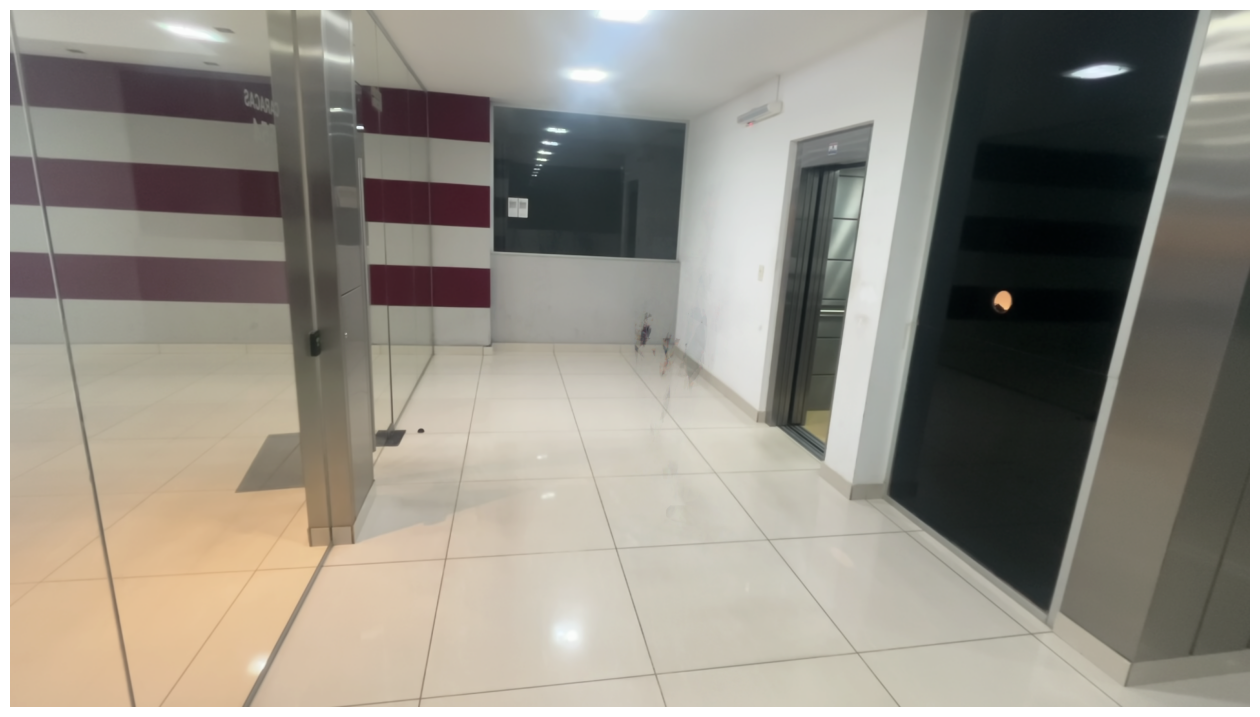

In [3]:
n_frames = 100
time_interval = 35 # in seconds
FILENAME = '../videos_for_testing/video6.mp4'
output_path = "./output/"

nbs = NaiveBackgroundSubstraction(n_frames, time_interval, FILENAME, output_path)

background = nbs.get_background()
plt.imshow(cv.cvtColor(background, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
vid_frames, titles = [], []

# imprimiendo un frame del video
capture = cv.VideoCapture(FILENAME)
capture.set(cv.CAP_PROP_POS_FRAMES, 540)
ret, frame = capture.read()
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.imshow(frame)
vid_frames.append(frame)
titles.append("ORIGINAL")
capture.release()
plt.axis('off')
plt.show()

Tiempo de procesamiento 39.683528900146484 segundos


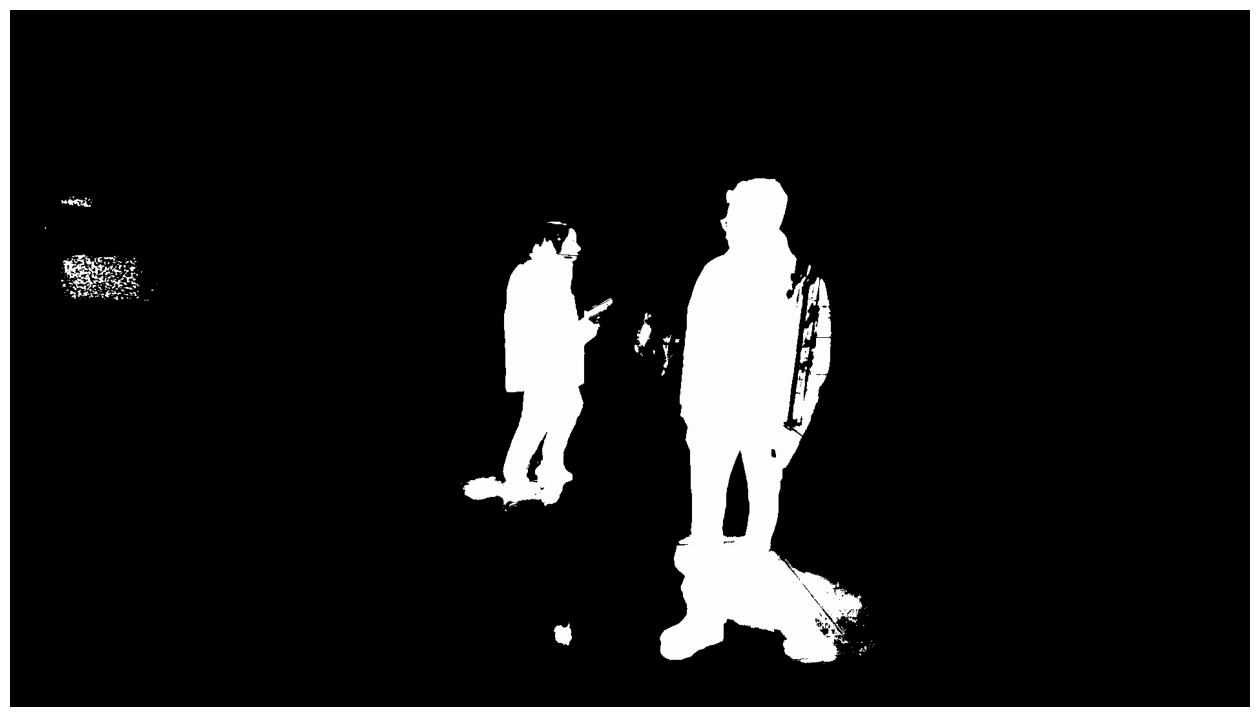

In [5]:
nbs.apply(visualize=False, output_filename="output_nbs.mp4")

# imprimiendo un frame del video
capture = cv.VideoCapture(output_path + "/output_nbs.mp4")
capture.set(cv.CAP_PROP_POS_FRAMES, 540)
ret, frame = capture.read()
plt.imshow(frame)
vid_frames.append(frame)
titles.append("NBS")
capture.release()
plt.axis('off')
plt.show()

## Con erosion para eliminar el ruido en la imagen binarizada

Tiempo de procesamiento 49.678499937057495 segundos


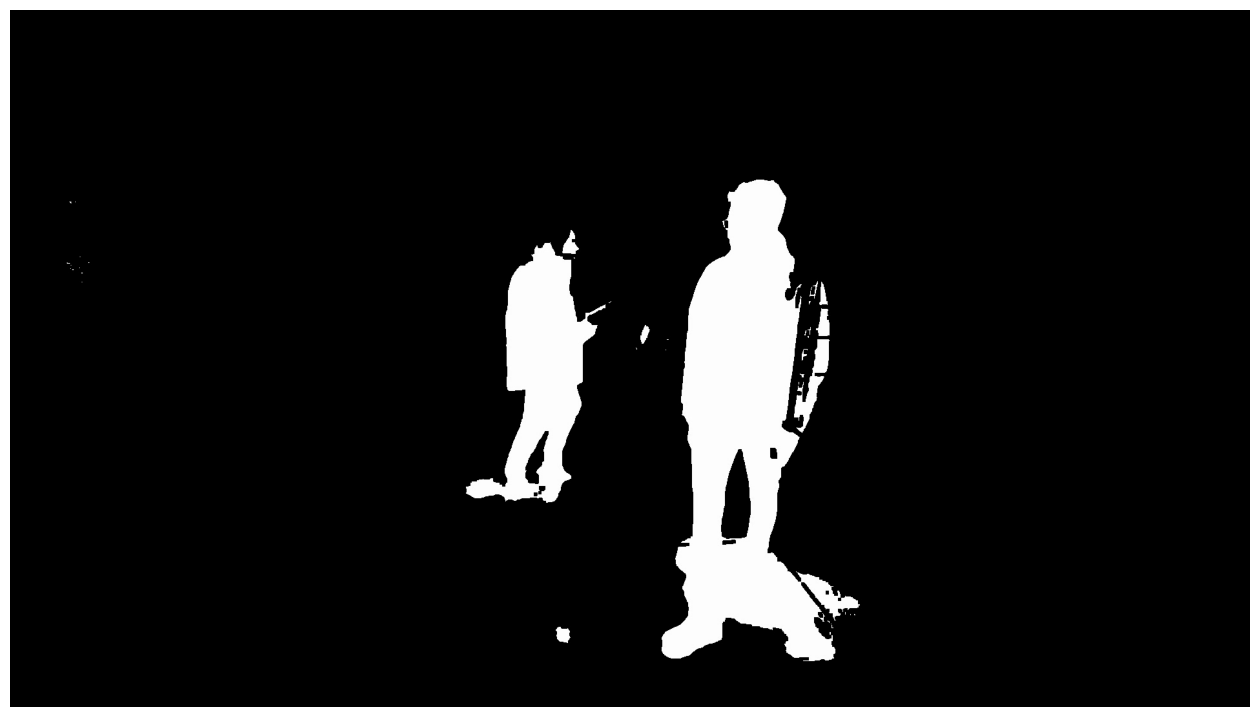

In [6]:
nbs.apply(erosion=True, visualize=False, output_filename="output_nbs_erosion.mp4")

# imprimiendo un frame del video
capture = cv.VideoCapture(output_path + "/output_nbs_erosion.mp4")
capture.set(cv.CAP_PROP_POS_FRAMES, 540)
ret, frame = capture.read()
plt.imshow(frame)
vid_frames.append(frame)
titles.append("NBS with erosion")
capture.release()
plt.axis('off')
plt.show()

## Con dilation

Tiempo de procesamiento 44.7416410446167 segundos


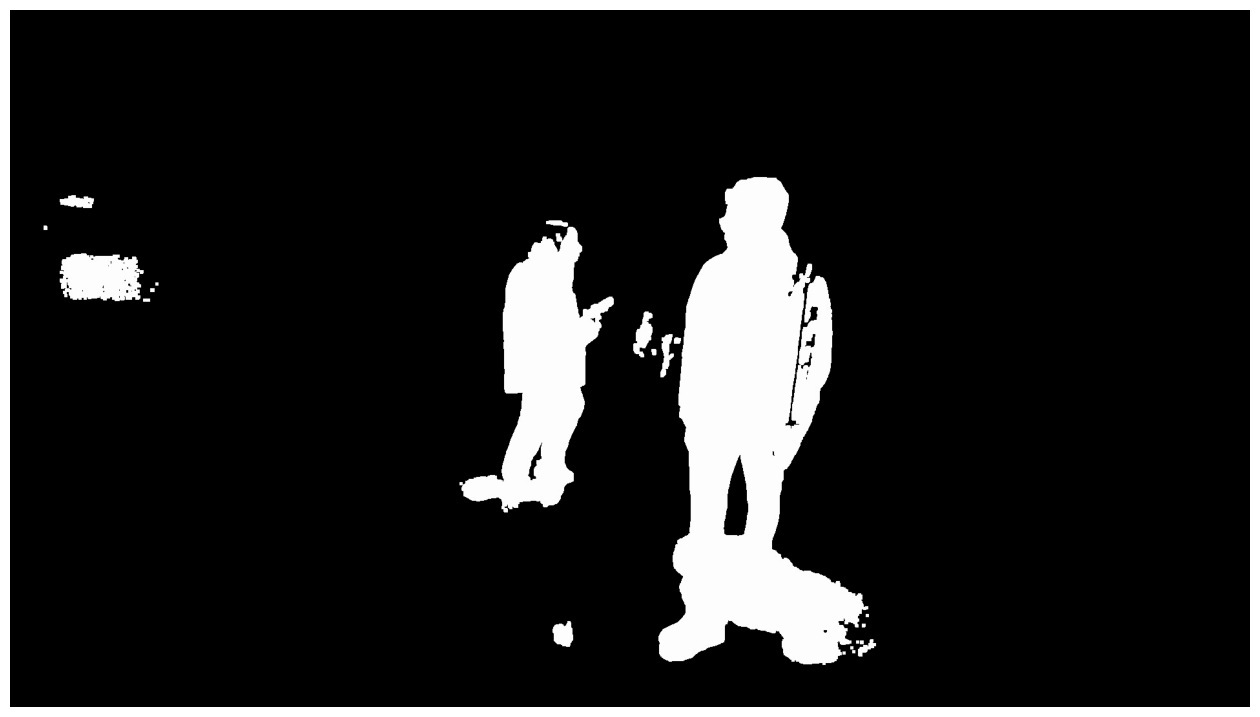

In [7]:
nbs.apply(dilation=True, visualize=False, output_filename="output_nbs_dilation.mp4")

# imprimiendo un frame del video
capture = cv.VideoCapture(output_path + "/output_nbs_dilation.mp4")
capture.set(cv.CAP_PROP_POS_FRAMES, 540)
ret, frame = capture.read()
plt.imshow(frame)
vid_frames.append(frame)
titles.append("NBS with dilation")
capture.release()
plt.axis('off')
plt.show()

## Con dilation y erosion

Tiempo de procesamiento 46.47749090194702 segundos


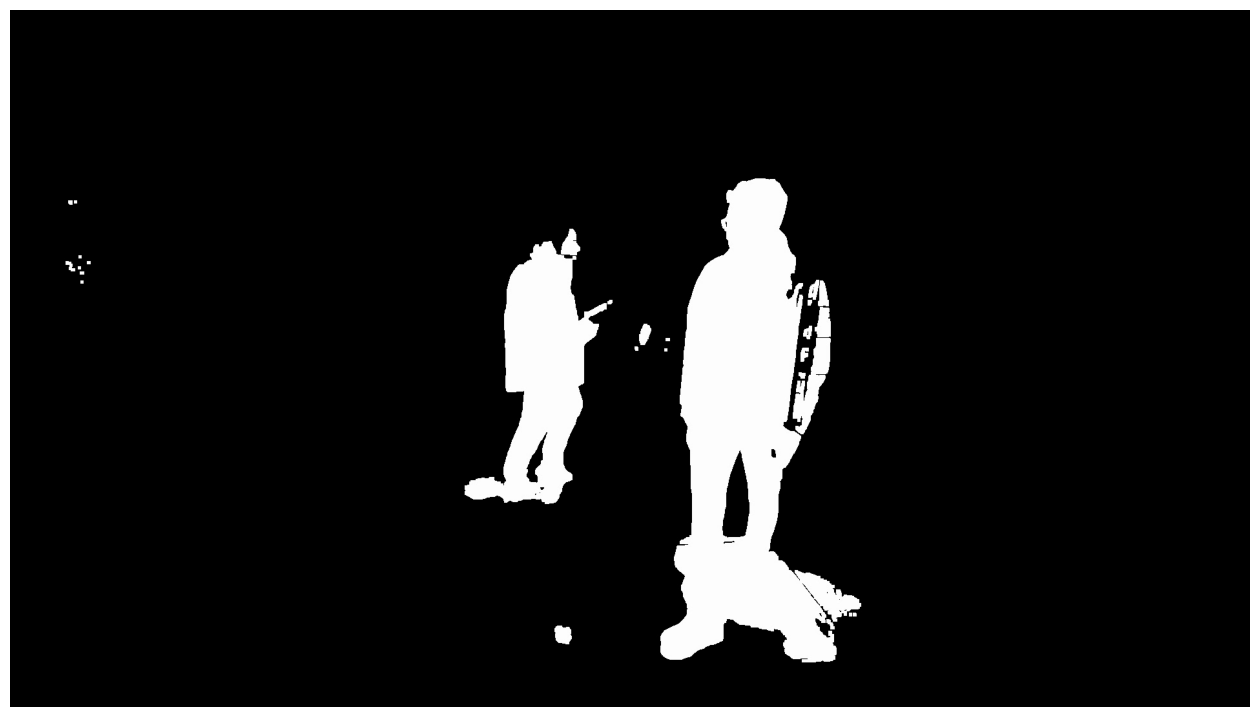

In [8]:
nbs.apply(erosion=True, dilation=True, visualize=False, output_filename="output_nbs_erosion_and_dilation.mp4")
nbs.release_capture()

# imprimiendo un frame del video
capture = cv.VideoCapture(output_path + "/output_nbs_erosion_and_dilation.mp4")
capture.set(cv.CAP_PROP_POS_FRAMES, 540)
ret, frame = capture.read()
plt.imshow(frame)
vid_frames.append(frame)
titles.append("NBS with erosion and dilation")
capture.release()
plt.axis('off')
plt.show()

# Comparando con MOG2

In [9]:
class MOG2BackgroundSubstraction:
    
    def __init__(self, filename, output_path=None):
        self.capture = cv.VideoCapture(filename)    
        if not self.capture.isOpened:
            print('Falla al abrir el archivo: ' + filename)
            exit(0)
            
        self.backSub = cv.createBackgroundSubtractorMOG2()
        
        self.fps = self.capture.get(cv.CAP_PROP_FPS)
        self.frame_width = int(self.capture.get(3))
        self.frame_height = int(self.capture.get(4))
        
        ## create output folder
        output_path = output_path if output_path else "./output/"
        folder_exists = os.path.exists(output_path)
        if not folder_exists: 
            os.makedirs(output_path)
        self.output_path = output_path
    
    def apply(self, visualize=True, output_filename=None, erosion=False, dilation=False):
        fourcc = cv.VideoWriter_fourcc(*'mp4v')
        
        output_filename = output_filename if output_filename else "output.mp4"
        
        output = cv.VideoWriter(self.output_path + "/" + output_filename,
                               fourcc,
                               self.fps,
                               (self.frame_width, self.frame_height),
                               False)
        
        # Reset frame number to 0
        self.capture.set(cv.CAP_PROP_POS_FRAMES, 0)
        
        # Corremos la sustraccion
        #------------------------
        start = time.time()      
        
        ret, frame = self.capture.read()
        
        while ret:
            # Leemos un frame
            if frame is None:
                break

            # Aplicamos la sustracción al frame leído
            #----------------------------------------
            # Cada frame se utiliza tanto para calcular la máscara de primer plano como para actualizar el fondo.
            # Si se desea cambiar la tasa de aprendizaje utilizada para actualizar el modelo de fondo, es posible
            # establecer una tasa de aprendizaje específica pasando un parámetro al método apply.
            fgMask = self.backSub.apply(frame)
            
            if erosion:
                kernel = np.ones((5,5),np.uint8)
                fgMask = cv.erode(fgMask, kernel, iterations = 1)
            
            if dilation:
                kernel = np.ones((5,5),np.uint8)
                fgMask = cv.dilate(fgMask, kernel, iterations = 1)
                
            output.write(fgMask)
            
            ret, frame = self.capture.read()
            
            # mostrando la imagen
            if visualize:
                cv.imshow('FG Mask', fgMask)
                # Corremos hasta que termine o apriete escape
                keyboard = cv.waitKey(30)
                if keyboard == 'q' or keyboard == 27:
                    break


        elapsed = time.time()-start
        print('Tiempo de procesamiento {} segundos'.format(elapsed))
        cv.destroyAllWindows()
        
    def release_capture(self):
        self.capture.release()

Tiempo de procesamiento 90.22061395645142 segundos


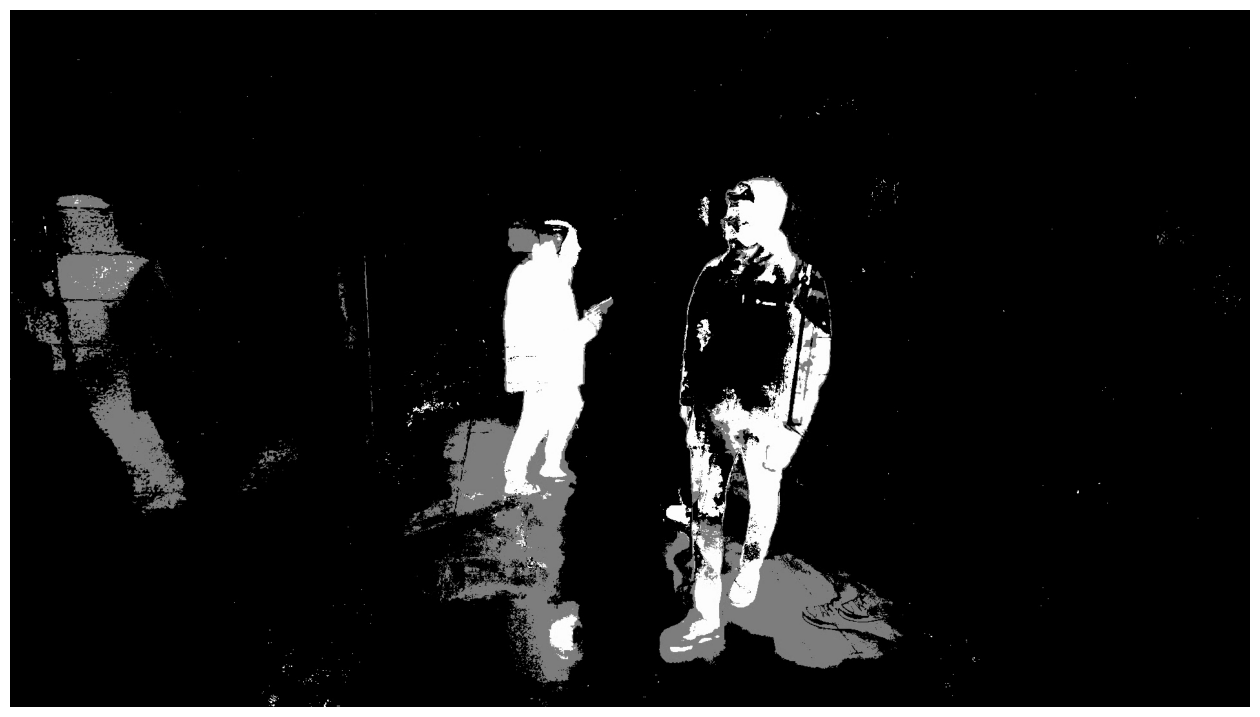

In [10]:
mog2 = MOG2BackgroundSubstraction(FILENAME)
mog2.apply(visualize=False, output_filename="output_mog2.mp4")

# imprimiendo un frame del video
capture = cv.VideoCapture(output_path + "/output_mog2.mp4")
capture.set(cv.CAP_PROP_POS_FRAMES, 540)
ret, frame = capture.read()
plt.imshow(frame)
vid_frames.append(frame)
titles.append("MOG2")
capture.release()
plt.axis('off')
plt.show()

Tiempo de procesamiento 83.47843599319458 segundos


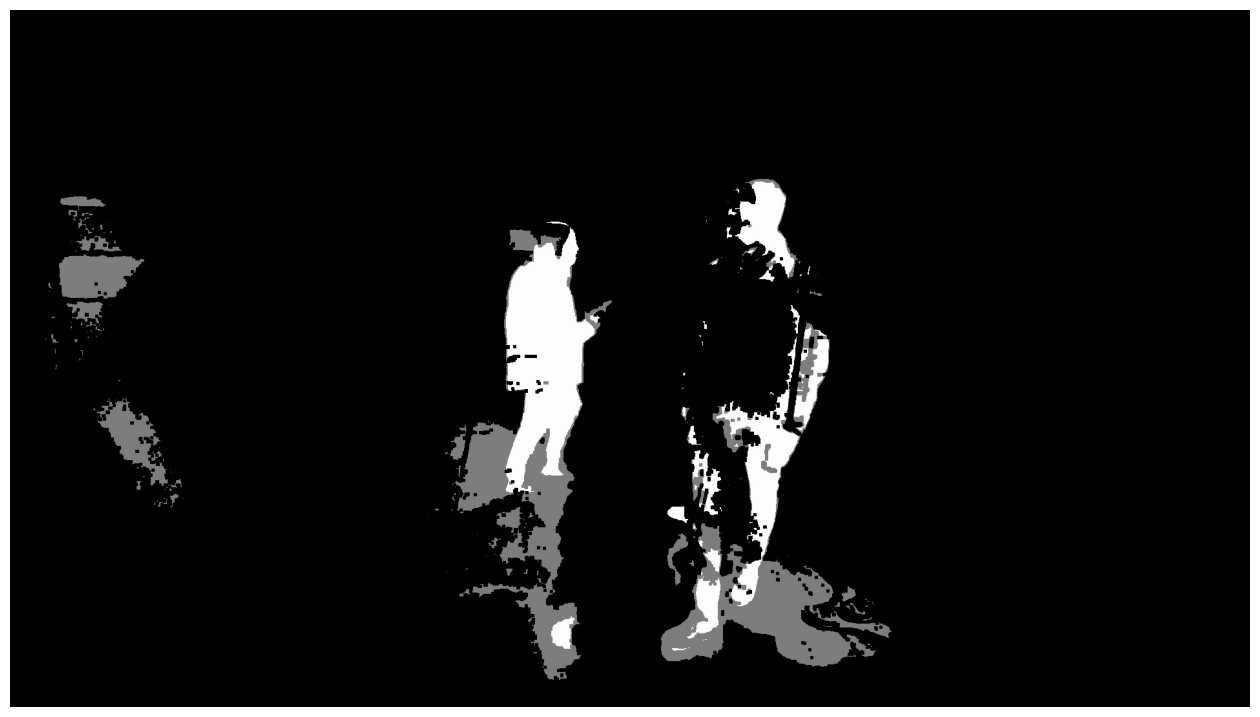

In [11]:
mog2 = MOG2BackgroundSubstraction(FILENAME)
mog2.apply(visualize=False, output_filename="output_mog2_erosion.mp4", erosion=True)

# imprimiendo un frame del video
capture = cv.VideoCapture(output_path + "/output_mog2_erosion.mp4")
capture.set(cv.CAP_PROP_POS_FRAMES, 540)
ret, frame = capture.read()
plt.imshow(frame)
vid_frames.append(frame)
titles.append("MOG2 with erosion")
capture.release()
plt.axis('off')
plt.show()

Tiempo de procesamiento 82.38771295547485 segundos


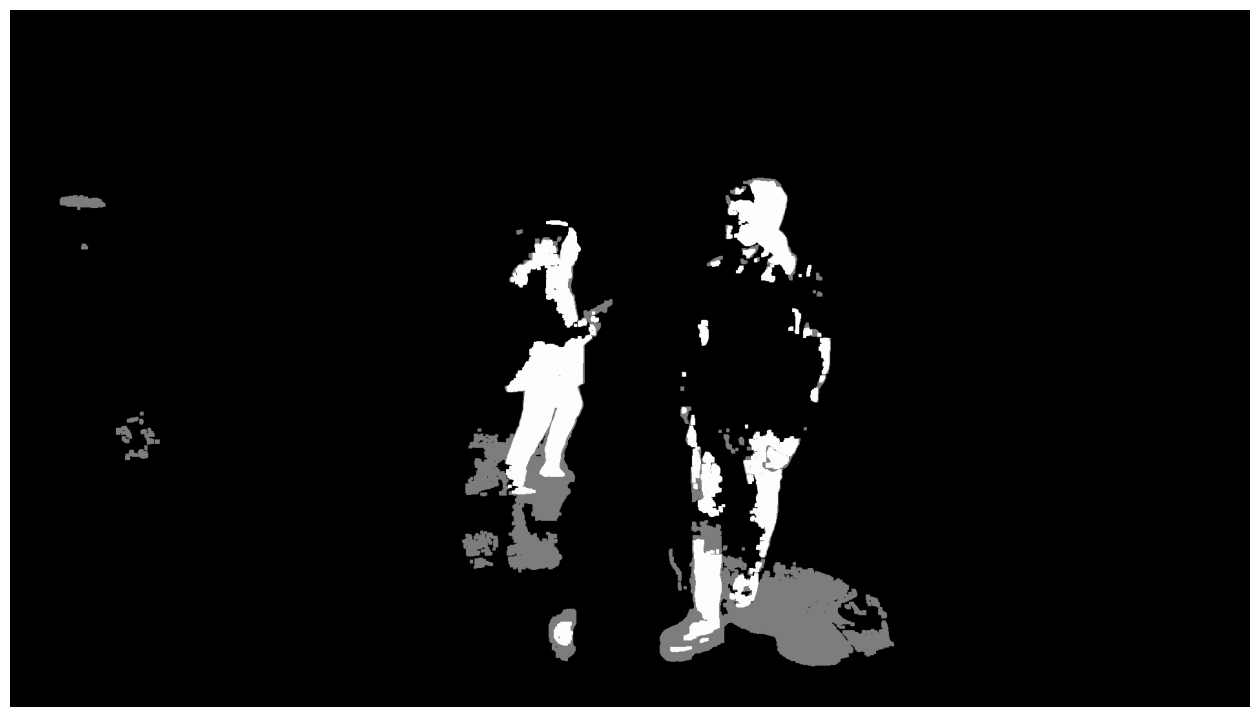

In [12]:
mog2.apply(visualize=False, output_filename="output_mog2_erosion_and_dilation.mp4", erosion=True, dilation=True)
mog2.release_capture()

# imprimiendo un frame del video
capture = cv.VideoCapture(output_path + "/output_mog2_erosion_and_dilation.mp4")
capture.set(cv.CAP_PROP_POS_FRAMES, 540)
ret, frame = capture.read()
plt.imshow(frame)
vid_frames.append(frame)
titles.append("MOG2 with erosion and dilation")
capture.release()
plt.axis('off')
plt.show()

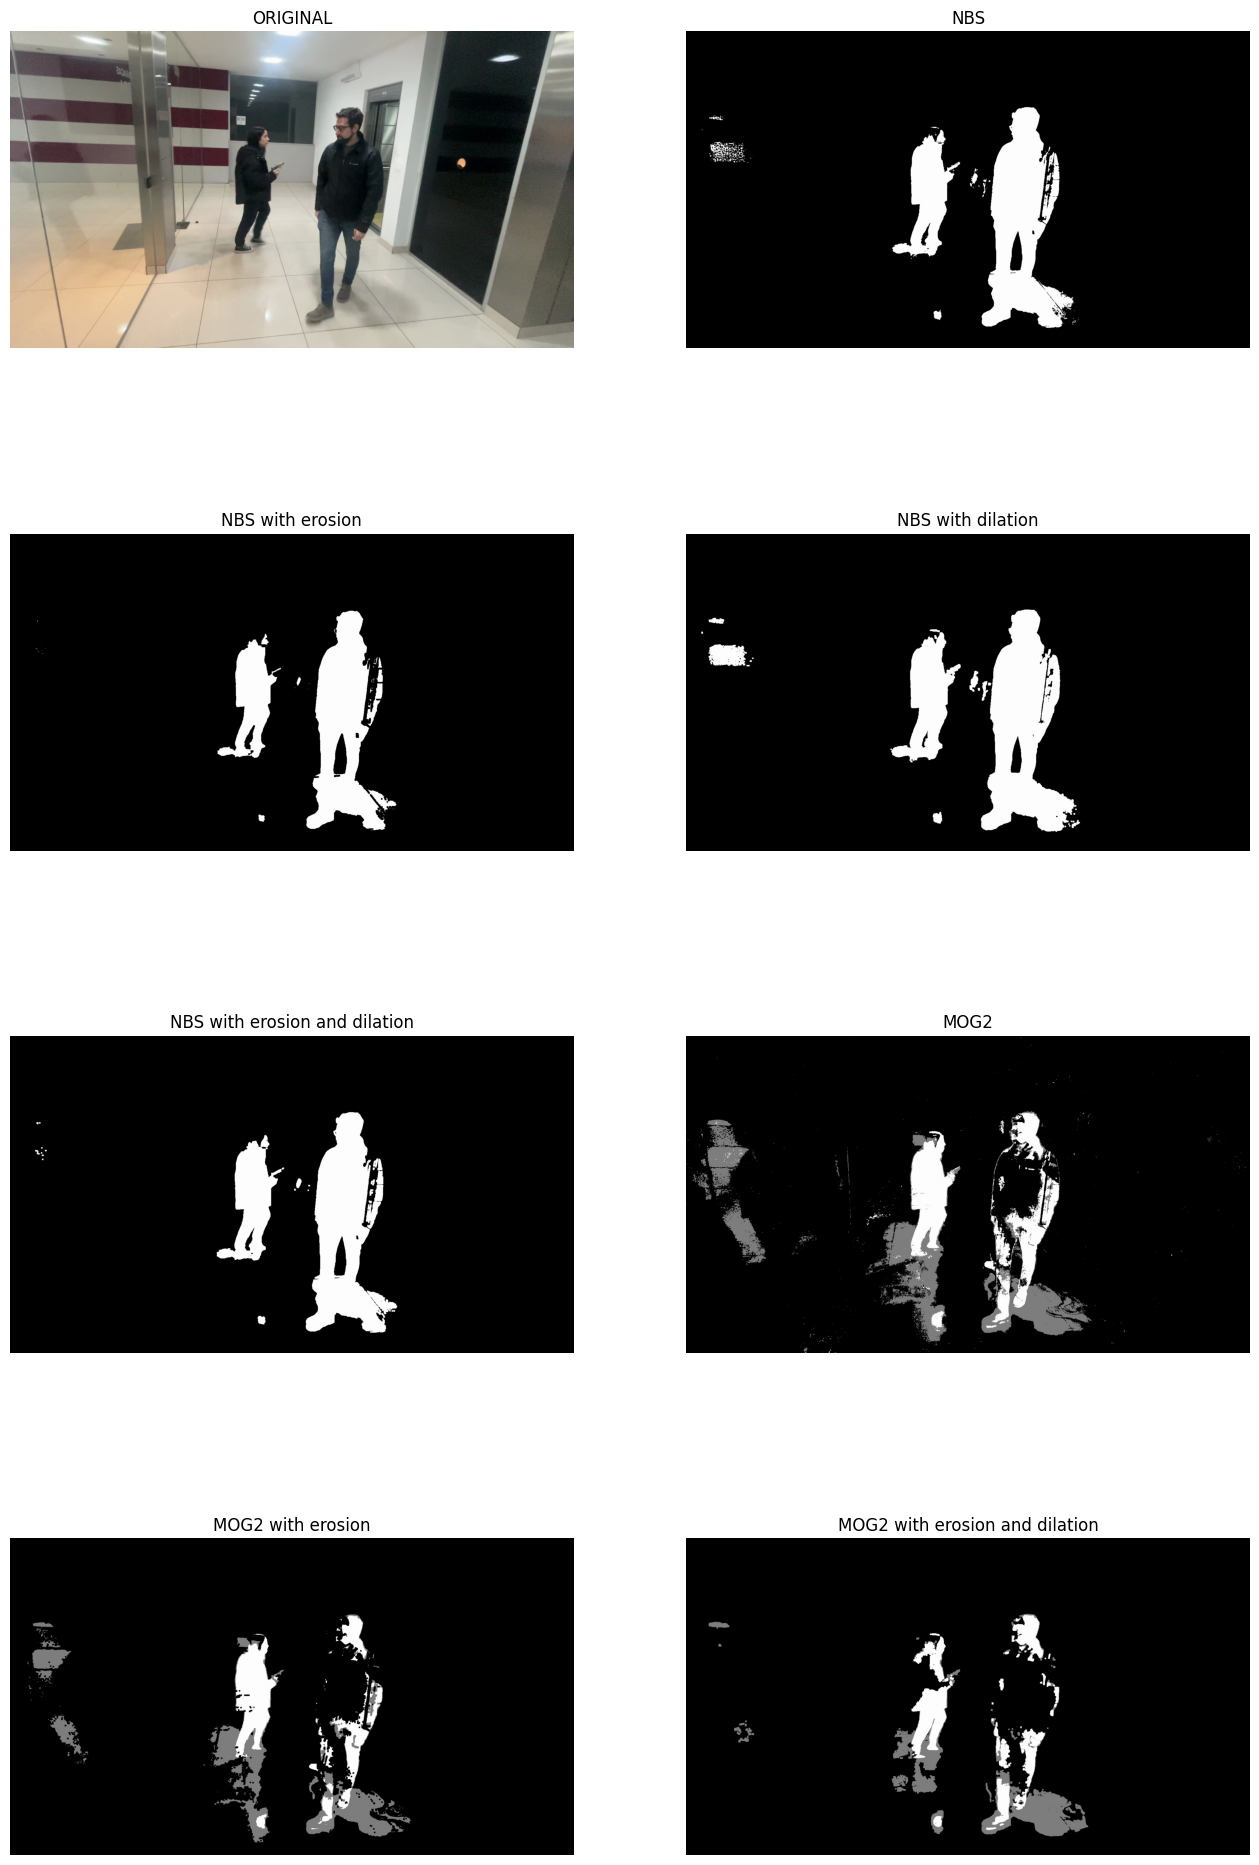

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(16.0, 25.0))
i = 0
j = 0
for k, img in enumerate(vid_frames):
    ax[i][j].imshow(img)
    ax[i][j].set_title(titles[k])
    ax[i][j].axis("off")
    j += 1
    if j == 2:
        i += 1
        j = 0
    
plt.show()

## Conclusiones

El algoritmo NBS detecta mejor el fondo que el algoritmo basado en mezcla de gausianas MOG2, teniendo una reducción de ruido significante. Sumado a esto, al utilizar NBS se vió una mejoría en los tiempos de runtime.

En este trabajo se hicieron pruebas con transformaciones morfológicas y en dichas pruebas se puede observar cómo con una combinación de erosion y dilation elimina por completo el ruido en la máscara de Foreground de NBS. Sin embargo, para MOG2 seguimos teniendo mucho ruido en el foreground.




# NBS with dilation and color

In [17]:
n_frames = 100
time_interval = 35 # in seconds
FILENAME = '../videos_for_testing/video6.mp4'
output_path = "./output/"

nbs = NaiveBackgroundSubstraction(n_frames, time_interval, FILENAME, output_path)

nbs.apply(erosion=True, dilation=True, visualize=True, output_filename="output_nbs_erosion_and_dilation2.mp4")
nbs.release_capture()

Tiempo de procesamiento 101.09274697303772 segundos
